In [95]:
import torch
import clip
from PIL import Image
import os # Import the 'os' module to handle file paths

# --- Configuration ---
# 1. Set the absolute path to your main datasets folder
# dataset_path = "/work/pcsl/sclocchi/datasets/"

# dataset_path = "/work/pcsl/sclocchi/datasets/"
dataset_path = "/work/pcsl/Noam/diffusion_datasets/selected_images"

# dataset_path = "/home/nlevi/Noam/SingleMaskDiffusion/guided-diffusion/datasets/tiny-imagenet-200/val/images"
# 2. Specify the image you want to analyze from that folder
#    IMPORTANT: Change "name_of_your_image.jpg" to a real image file name.
#    For example, if you have an ImageNet image: "n02123045_31.JPEG"
# image_filename = "ILSVRC2012/validation/n02128757/n02128757_ILSVRC2012_val_00005277.JPEG" 


image_filename = "ILSVRC2012_val_00006002.JPEG" 


# n

# 3. Define your text prompts
text_prompts = ["a photo of a diagram", "a photo of a dog", "a photo of a bird"]
# --- End of Configuration ---


# Construct the full path to the image
full_image_path = os.path.join(dataset_path, image_filename)

# Check if the image file actually exists before proceeding
if not os.path.exists(full_image_path):
    print(f"Error: Image not found at {full_image_path}")
    print("Please make sure 'dataset_path' and 'image_filename' are set correctly.")
else:
    # Set up the device and load the CLIP model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    # Preprocess the image and tokenize the text
    image = preprocess(Image.open(full_image_path)).unsqueeze(0).to(device)
    text = clip.tokenize(text_prompts).to(device)

    # Perform inference
    with torch.no_grad():
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    print(f"Analysis for image: {image_filename}")
    print("Label probabilities:", probs)
    
    # Print a more readable output
    print("\n--- Results ---")
    for i, prompt in enumerate(text_prompts):
        print(f"{prompt}: {probs[0, i]*100:.2f}%")

Analysis for image: ILSVRC2012_val_00006002.JPEG
Label probabilities: [[0.001646  0.997     0.0012045]]

--- Results ---
a photo of a diagram: 0.16%
a photo of a dog: 99.71%
a photo of a bird: 0.12%


In [97]:
os.listdir(dataset_path);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7070738..1.8188357].


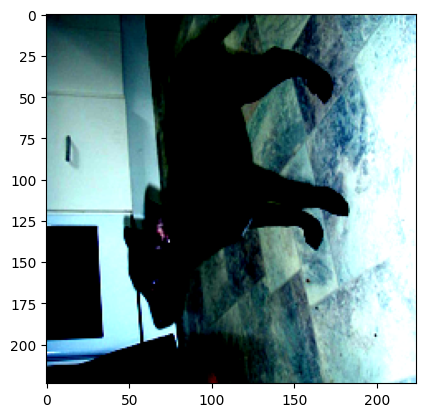

In [96]:
plt.imshow(image.cpu().detach().reshape(3,224,224).T) 

In [98]:
# path = "../datasets/ILSVRC2012/validation/n02128757/n02128757_ILSVRC2012_val_00005277.JPEG"


path = full_image_path

In [99]:
image = preprocess(Image.open(path)).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a bird", "a leopard", "a snow leopard"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.00349  0.8027   0.00308  0.1819   0.009056]]


In [100]:
image_features.shape

torch.Size([1, 512])

In [101]:
import torch
import numpy as np
import pickle
import time
# import matplotlib.pyplot as plt
from PIL import Image


def center_crop_arr(pil_image, image_size):
    # We are not on a new enough PIL to support the `reducing_gap`
    # argument, which uses BOX downsampling at powers of two first.
    # Thus, we do it by hand to improve downsample quality.
    while min(*pil_image.size) >= 2 * image_size:
        pil_image = pil_image.resize(
            tuple(x // 2 for x in pil_image.size), resample=Image.BOX
        )

    scale = image_size / min(*pil_image.size)
    pil_image = pil_image.resize(
        tuple(round(x * scale) for x in pil_image.size), resample=Image.BICUBIC
    )

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return arr[crop_y : crop_y + image_size, crop_x : crop_x + image_size]


def load_image(path, crop=False):
    img = Image.open(path)
    img = img.convert('RGB')
    if crop:
        img = center_crop_arr(img, 256)
    img = np.array(img)
    img = img.transpose(2, 0, 1)
    img = img / 255
    return img

In [102]:
image = preprocess(Image.open(path)).unsqueeze(0).to(device)
type(image), image.shape, image.dtype

(torch.Tensor, torch.Size([1, 3, 224, 224]), torch.float32)

In [103]:
import torch
from PIL import Image

# Assuming preprocess and model are already defined
# image = preprocess(Image.open(path)).unsqueeze(0).to(device)
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
# print(image.shape), print(type(image))
image = Image.fromarray(image)

image = preprocess(image).unsqueeze(0).to(device)
print(image.shape)

# Hook to get intermediate transformer outputs
dict_activation = {}
# def get_intermediate_features(module, input, output):
#     dict_activation[module] = output
#     return output
def get_activation(name):
    def hook(model, input, output):
        dict_activation[name] = output.detach()
    return hook

target_modules = ['transformer', 'conv1'] + ['transformer.resblocks.'+str(i) for i in range(12)] + ['ln_post']

# Register a hook on the transformer to get token-wise embeddings
# handle = model.visual.transformer.register_forward_hook(get_intermediate_features)
for name, module in model.visual.named_modules():
    if name in target_modules:
        module.register_forward_hook(get_activation(name))



# Pass the image through the model
with torch.no_grad():
    image_features = model.encode_image(image)

# # Access the token-wise features
# # Assuming you want the output from the specific layer you registered the hook on
# token_features = list(dict_activation.values())[0]  # This will be the sequence of token embeddings

# # Don't forget to remove the hook when done
# handle.remove()

# # Now you can use token_features as needed
# print(token_features.shape)

# Print the activations
print('Image features:', image_features.shape)
for name, activation in dict_activation.items():
    print(f'{name}: {activation.shape}')

torch.Size([1, 3, 224, 224])
Image features: torch.Size([1, 512])
conv1: torch.Size([1, 768, 7, 7])
transformer.resblocks.0: torch.Size([50, 1, 768])
transformer.resblocks.1: torch.Size([50, 1, 768])
transformer.resblocks.2: torch.Size([50, 1, 768])
transformer.resblocks.3: torch.Size([50, 1, 768])
transformer.resblocks.4: torch.Size([50, 1, 768])
transformer.resblocks.5: torch.Size([50, 1, 768])
transformer.resblocks.6: torch.Size([50, 1, 768])
transformer.resblocks.7: torch.Size([50, 1, 768])
transformer.resblocks.8: torch.Size([50, 1, 768])
transformer.resblocks.9: torch.Size([50, 1, 768])
transformer.resblocks.10: torch.Size([50, 1, 768])
transformer.resblocks.11: torch.Size([50, 1, 768])
transformer: torch.Size([50, 1, 768])
ln_post: torch.Size([1, 768])


In [65]:
tt = torch.tensor([[1,2], [3,4]])
print(tt)
flat = tt.reshape(-1)
print(flat)
print(flat.reshape(2,2))

tensor([[1, 2],
        [3, 4]])
tensor([1, 2, 3, 4])
tensor([[1, 2],
        [3, 4]])


In [66]:
for key in dict_activation.keys():
    print(key)

for val in dict_activation.values():
    print(val.shape)

conv1
transformer.resblocks.0
transformer.resblocks.1
transformer.resblocks.2
transformer.resblocks.3
transformer.resblocks.4
transformer.resblocks.5
transformer.resblocks.6
transformer.resblocks.7
transformer.resblocks.8
transformer.resblocks.9
transformer.resblocks.10
transformer.resblocks.11
transformer
ln_post
torch.Size([1, 768, 7, 7])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([50, 1, 768])
torch.Size([1, 768])


(256, 256, 3)
<class 'numpy.ndarray'>


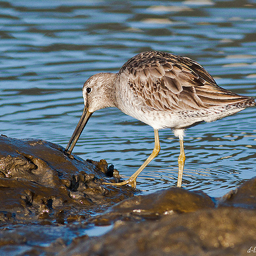

In [67]:
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
print(image.shape), print(type(image))
image = Image.fromarray(image)
type(image)
image

torch.Size([1, 3, 224, 224])


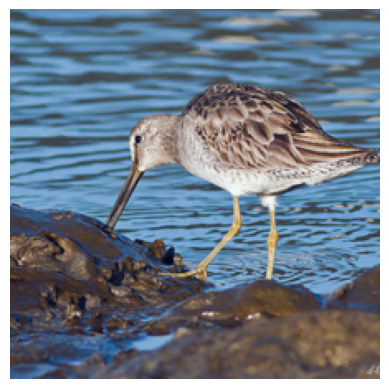

In [68]:
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
# print(image.shape), print(type(image))
image = Image.fromarray(image)

image = preprocess(image).unsqueeze(0).to(device)
print(image.shape)

im = image[0]
# Normalize the image
im -= im.min()
im /= im.max()
im = im.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots()
ax.imshow(im)
ax.axis('off')
ax.set_aspect('equal')
# fig.tight_layout()
# plt.savefig(f'../../plots/clip-downsized_leo.png', dpi = 400, bbox_inches='tight')
plt.show()

In [69]:
# image = load_image(path, crop=True) * 255
# image = image.transpose(1,2,0).astype(np.uint8) 
# # print(image.shape), print(type(image))
# # image = Image.fromarray(image)

# image = preprocess(image).unsqueeze(0).to(device)



# Assuming load_image and transpose are necessary for your workflow
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 

# --- THIS IS THE FIX ---
# Convert the NumPy array back to a PIL Image before preprocessing
image = Image.fromarray(image)
# ----------------------

# Now preprocess will work because its input is a PIL Image
image = preprocess(image).unsqueeze(0).to(device)


torch.Size([1, 3, 224, 224])


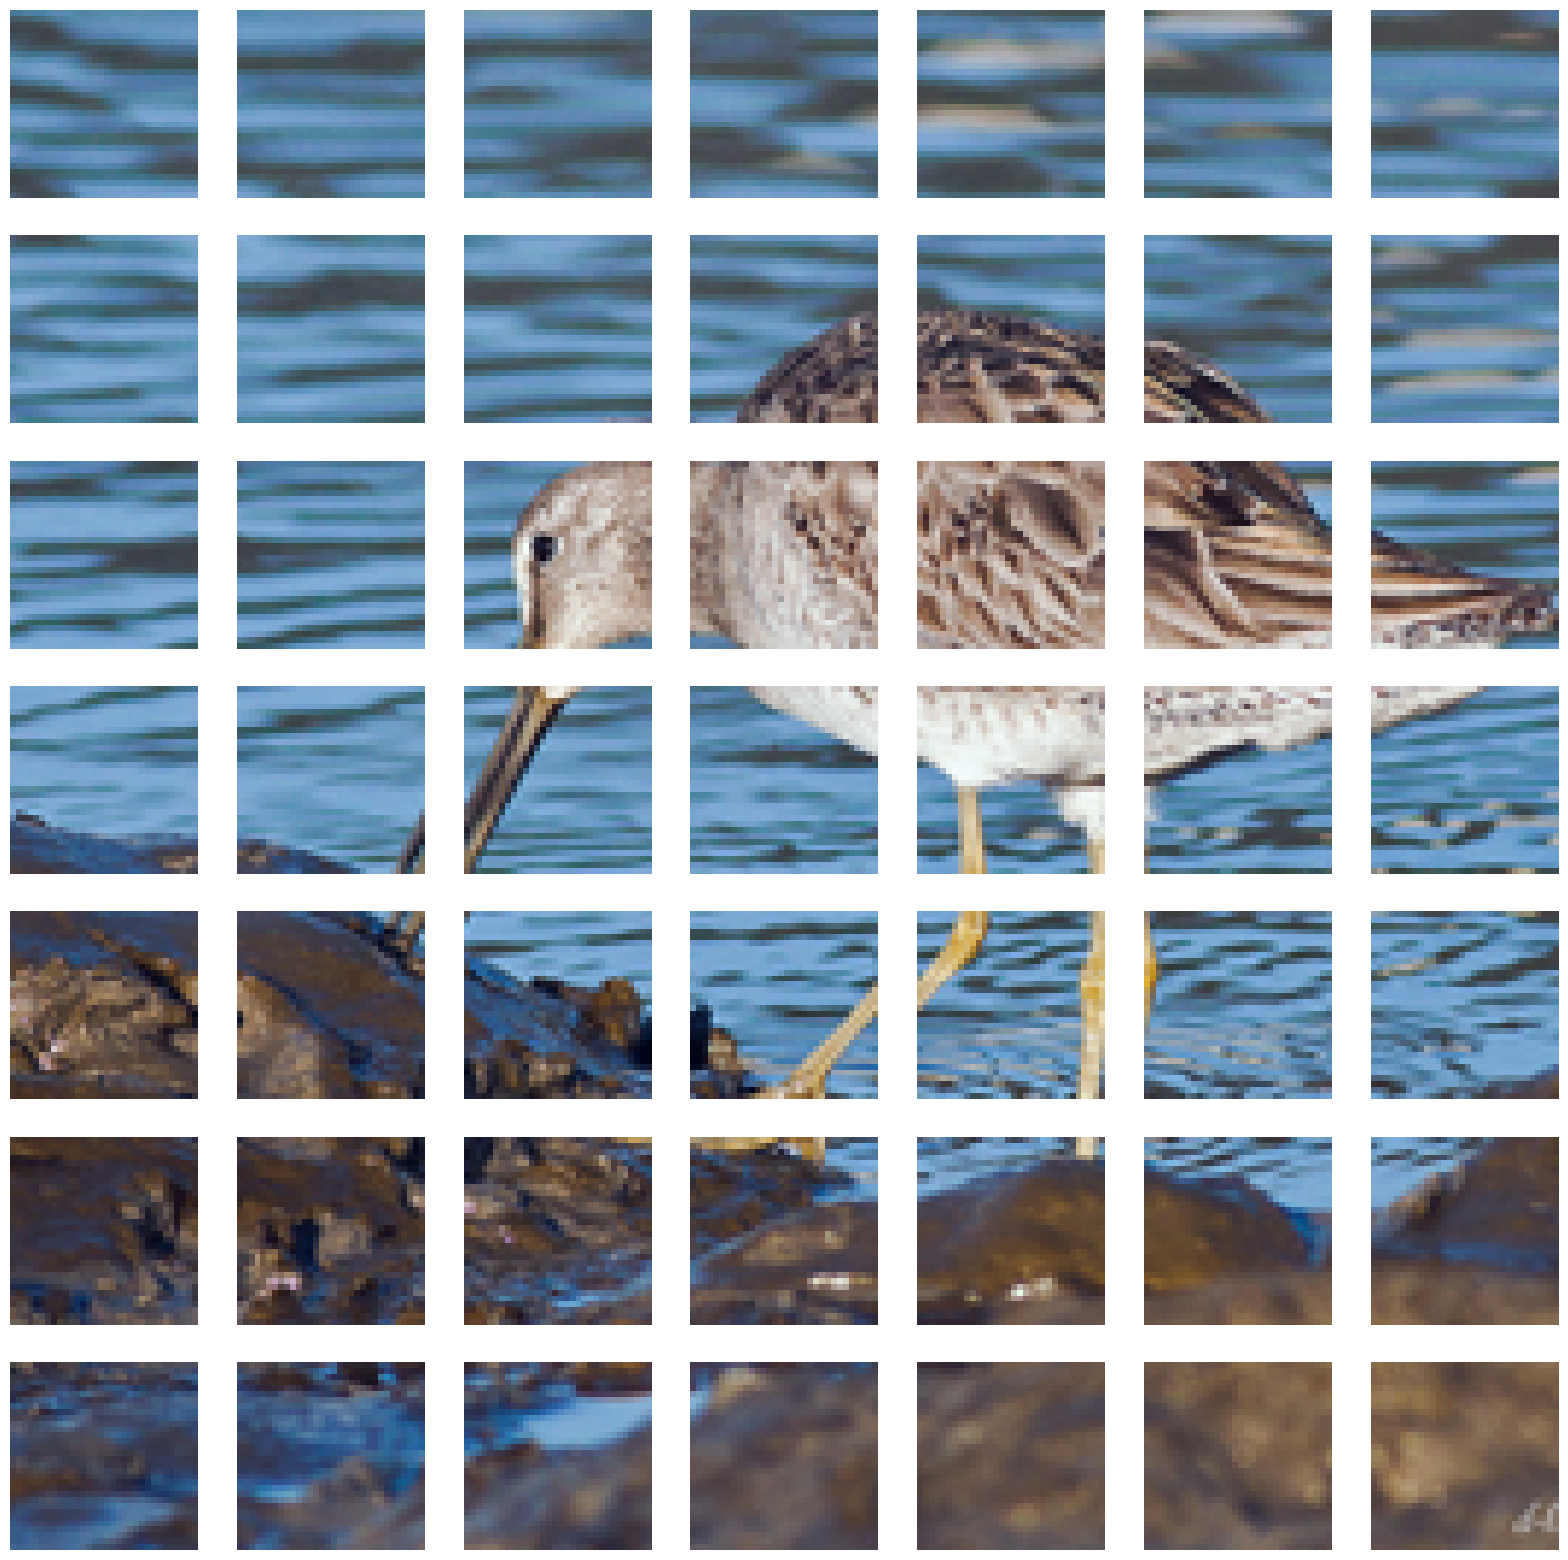

In [70]:
image = load_image(path, crop=True) * 255
image = image.transpose(1,2,0).astype(np.uint8) 
# print(image.shape), print(type(image))
image = Image.fromarray(image)

image = preprocess(image).unsqueeze(0).to(device)
print(image.shape)

im = image[0]
# Normalize the image
im -= im.min()
im /= im.max()
im = im.permute(1,2,0).cpu().numpy()

fig, axs = plt.subplots(7,7, figsize=(20,20))
size = 32

for i in range(7):
    for j in range(7):
        axs[i,j].imshow(im[i*size:(i+1)*size, j*size:(j+1)*size, :])
        axs[i,j].axis('off')
        axs[i,j].set_aspect('equal')
# fig.tight_layout()
# plt.savefig(f'../../plots/clip-tokenized_leo.png', dpi = 400, bbox_inches='tight')
plt.show()

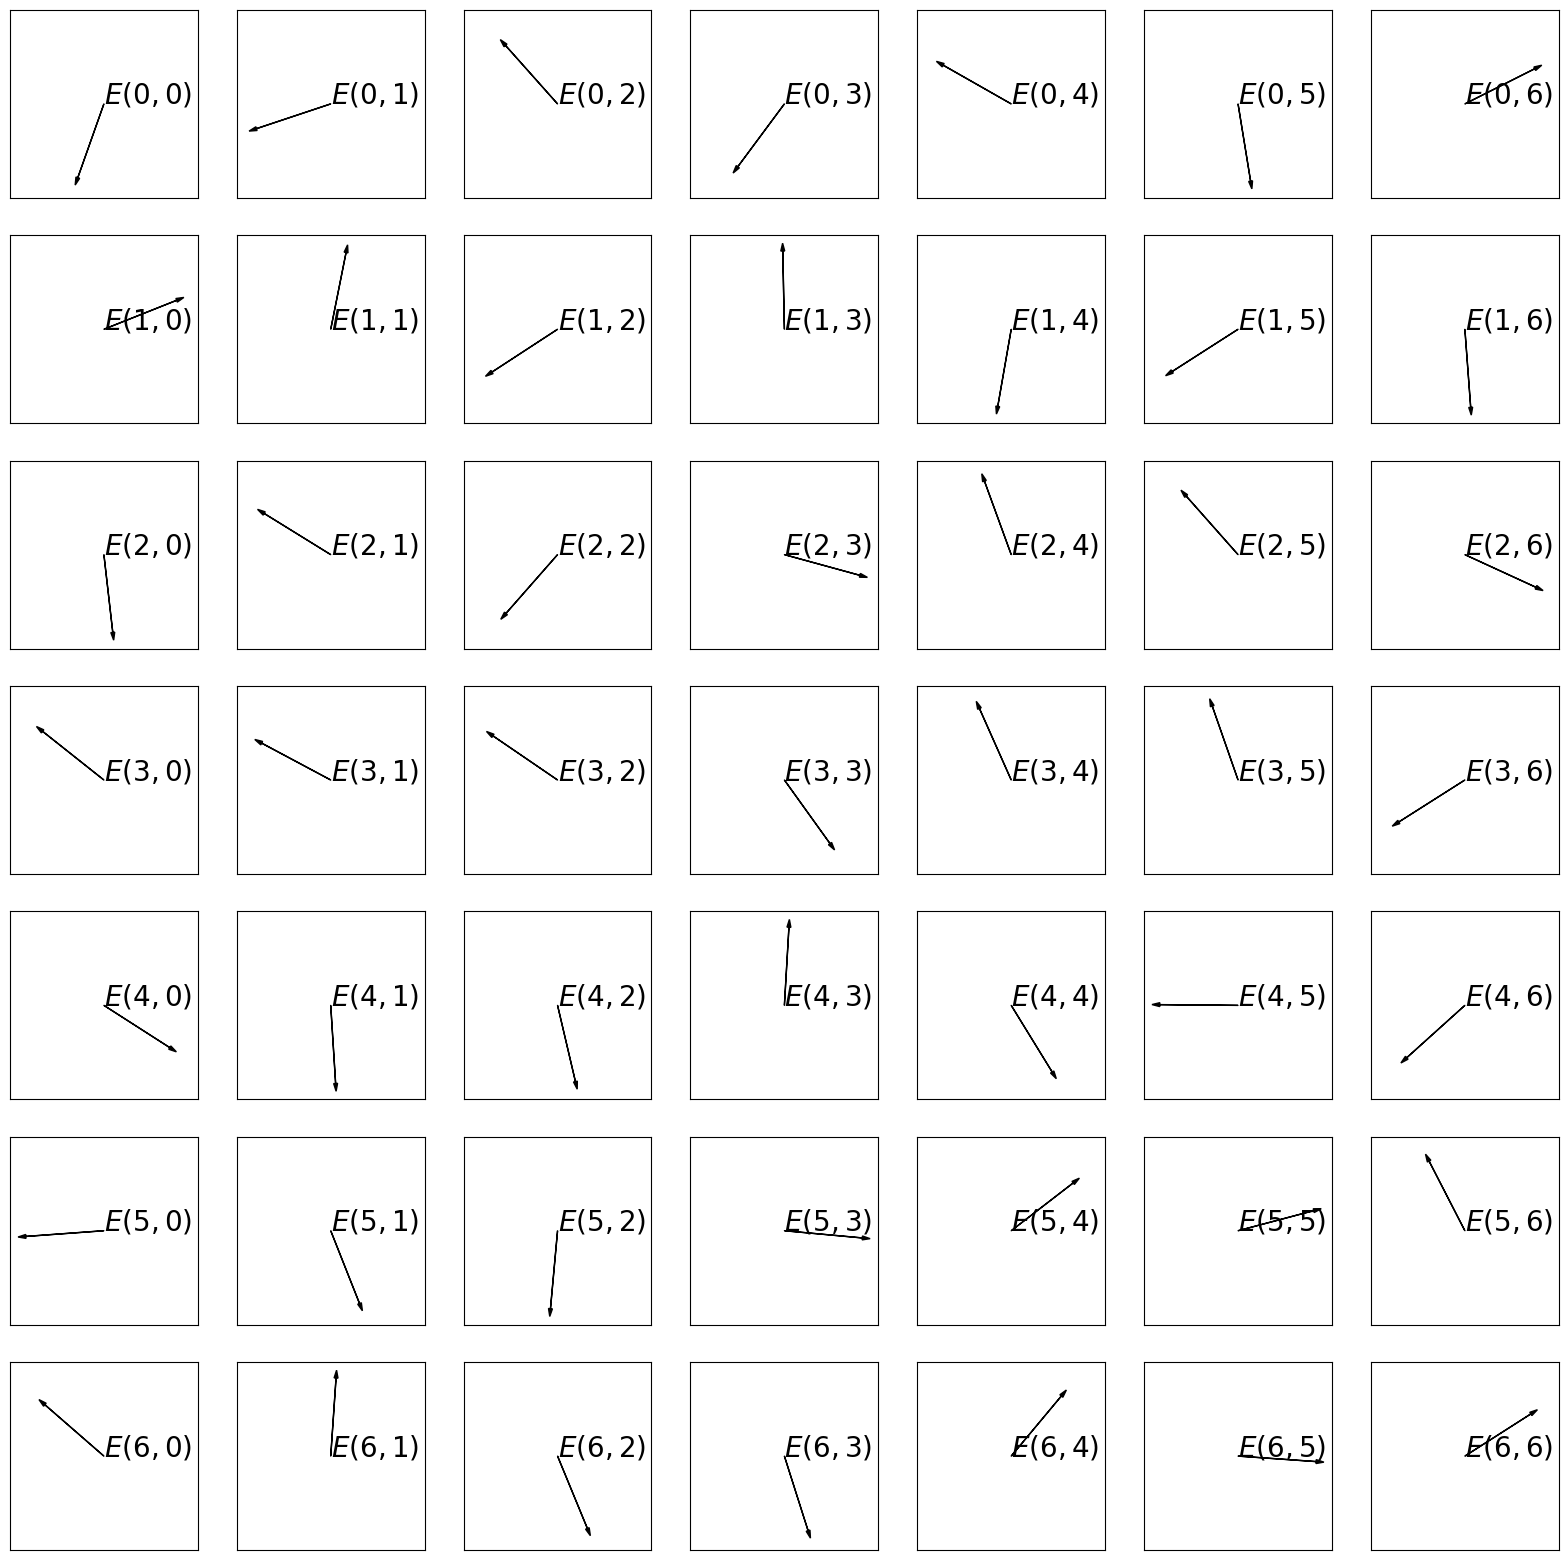

In [71]:
fig, axs = plt.subplots(7,7, figsize=(20,20))

for i in range(7):
    for j in range(7):
        # axs[i,j].imshow(im[i*size:(i+1)*size, j*size:(j+1)*size, :])
        axs[i,j].text(0, 0, f'$E{i,j}$', color='black', fontsize=20, fontweight='bold',)
        arr = np.random.randn(2)
        arr /= np.linalg.norm(arr)
        axs[i,j].arrow(0, 0, arr[0], arr[1], head_width=0.05, head_length=0.1, fc='k', ec='k')
        # axs[i,j].axis('off')
        axs[i,j].set_aspect('equal')
        axs[i,j].set_xlim(-1.2, 1.2)
        axs[i,j].set_ylim(-1.2, 1.2)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
# fig.tight_layout()
# plt.savefig(f'../../plots/clip-embedding.png', dpi = 300, bbox_inches='tight')
plt.show()

In [72]:
im.max(), im.min()

(1.0, 0.0)

(224, 224, 3)

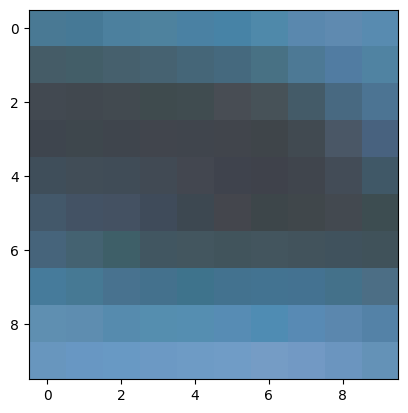

In [73]:
plt.imshow(image[0].permute(1,2,0).cpu().numpy()[:10, :10, :])
image[0].permute(1,2,0).cpu().numpy().shape

In [74]:
im.shape

(224, 224, 3)

In [75]:
for name, module in model.visual.named_modules():
    print(name)
    # if name in target_modules:
        # module.register_forward_hook(get_activation(name))

['conv1'] + ['transformer.resblocks.'+str(i) for i in range(12)] + ['ln_post']



conv1
ln_pre
transformer
transformer.resblocks
transformer.resblocks.0
transformer.resblocks.0.attn
transformer.resblocks.0.attn.out_proj
transformer.resblocks.0.ln_1
transformer.resblocks.0.mlp
transformer.resblocks.0.mlp.c_fc
transformer.resblocks.0.mlp.gelu
transformer.resblocks.0.mlp.c_proj
transformer.resblocks.0.ln_2
transformer.resblocks.1
transformer.resblocks.1.attn
transformer.resblocks.1.attn.out_proj
transformer.resblocks.1.ln_1
transformer.resblocks.1.mlp
transformer.resblocks.1.mlp.c_fc
transformer.resblocks.1.mlp.gelu
transformer.resblocks.1.mlp.c_proj
transformer.resblocks.1.ln_2
transformer.resblocks.2
transformer.resblocks.2.attn
transformer.resblocks.2.attn.out_proj
transformer.resblocks.2.ln_1
transformer.resblocks.2.mlp
transformer.resblocks.2.mlp.c_fc
transformer.resblocks.2.mlp.gelu
transformer.resblocks.2.mlp.c_proj
transformer.resblocks.2.ln_2
transformer.resblocks.3
transformer.resblocks.3.attn
transformer.resblocks.3.attn.out_proj
transformer.resblocks.3.ln_

['conv1',
 'transformer.resblocks.0',
 'transformer.resblocks.1',
 'transformer.resblocks.2',
 'transformer.resblocks.3',
 'transformer.resblocks.4',
 'transformer.resblocks.5',
 'transformer.resblocks.6',
 'transformer.resblocks.7',
 'transformer.resblocks.8',
 'transformer.resblocks.9',
 'transformer.resblocks.10',
 'transformer.resblocks.11',
 'ln_post']

In [76]:
# model.visual.__dir__()
for mod in model.visual.named_modules():
    print(mod)

('', VisionTransformer(
  (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
  (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (transformer): Transformer(
    (resblocks): Sequential(
      (0): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): QuickGELU()
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (ln_1): LayerNorm((768,), eps=1e-05, elemen

In [77]:
dict_activation.keys()

dict_keys(['conv1', 'transformer.resblocks.0', 'transformer.resblocks.1', 'transformer.resblocks.2', 'transformer.resblocks.3', 'transformer.resblocks.4', 'transformer.resblocks.5', 'transformer.resblocks.6', 'transformer.resblocks.7', 'transformer.resblocks.8', 'transformer.resblocks.9', 'transformer.resblocks.10', 'transformer.resblocks.11', 'transformer', 'ln_post'])

In [78]:
224/32

7.0

In [79]:
img = Image.open(path)
type(img)

PIL.JpegImagePlugin.JpegImageFile

# Tokens embeddings

In [80]:
def embed(visual, x: torch.Tensor):
    with torch.no_grad():
        x = visual.conv1(x)  # shape = [*, width, grid, grid]
        x = x.reshape(x.shape[0], x.shape[1], -1)  # shape = [*, width, grid ** 2]
        x = x.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
        x = torch.cat([visual.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device), x], dim=1)  # shape = [*, grid ** 2 + 1, width]
        x = x + visual.positional_embedding.to(x.dtype)
        x = visual.ln_pre(x)

        x = x.permute(1, 0, 2)  # NLD -> LND
        x = visual.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD

        class_token = visual.ln_post(x[:, 0, :])

        class_token = class_token @ visual.proj

        x = x[:, 1:, :]
        x = x.reshape(x.shape[0], 7, 7, x.shape[2])

        return x, class_token

# toks, glob = embed(model.visual, image)

toks, glob = embed(model.visual, image.half())

print(glob.shape, toks.shape)

torch.Size([1, 512]) torch.Size([1, 7, 7, 768])


In [81]:
toks.norm(dim=-1)

tensor([[[16.0625, 16.9375, 17.2656, 16.9688, 17.2031, 17.7656, 18.0938],
         [17.1719, 18.6875, 17.7188, 17.7812, 18.1094, 17.7969, 16.7031],
         [17.2344, 17.4531, 18.9375, 18.2031, 17.2500, 18.0625, 17.8594],
         [17.5156, 19.0625, 19.1094, 18.4375, 18.8594, 18.0312, 16.6406],
         [17.8906, 15.8672, 18.2344, 17.5000, 18.3438, 16.8281, 17.9531],
         [17.8750, 17.4062, 18.0469, 17.5625, 16.8281, 17.7188, 16.6562],
         [19.2031, 19.0000, 18.7188, 17.4062, 17.7656, 18.6094, 18.2656]]],
       device='cuda:0', dtype=torch.float16)

In [82]:
768**0.5

27.712812921102035

# File analysis

In [83]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import time

from collections import defaultdict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [84]:
def compute_correlation_function(size, C):
    size2 = size*size
    # file = '/scratch/sclocchi/guided-diffusion/correlations_measurements/diffused_ILSVRC2012_validation/correlations_deltaX-t_100_250-magnitude.pk'
    # print("Loading data...", flush=True)
    # with open(args.file, 'rb') as f:
    #     data = pickle.load(f)
    # print("Data loaded.", flush=True)

    # print('Computing correlation matrix...', flush=True)
    # C = data['corr'].reshape(size2, size2) - data['mean'].reshape(size2, 1) @ data['mean'].reshape(1, size2)
    # print('Computed correlation matrix.', flush=True)

    # print('Deleting data...', flush=True)
    # del data
    # print('Deleted data.', flush=True)

    print('Computing indeces...', flush=True)
    idx = torch.triu_indices(size2, size2, offset=0)
    print('Computed indeces.', flush=True)

    print('Computing C values...', flush=True)
    Cvalues = torch.tensor(C[idx[0], idx[1]])
    print('Computed C values.', flush=True)

    # print('Deleting C...', flush=True)
    # del C
    # print('Deleted C.', flush=True)

    print('Computing distances...', flush=True)
    labels = ((idx[1]//size) - (idx[0]//size))**2 
    labels += ((idx[1]%size) - (idx[0]%size))**2
    # file_labels = f'/scratch/sclocchi/guided-diffusion/correlations_measurements/labels_{args.image_size}.pt'
    # lab_dic = torch.load(file_labels)
    # labels = lab_dic['labels']
    # del lab_dic
    # print('Computed distances.', flush=True)

    # if args.unique_labels is not None:
    #     lab_dic = torch.load(f)
    #     unique_labels = lab_dic['labels']
    #     labels_count = lab_dic['labels_count']
    # else:

    print('Computing unique labels...', flush=True)
    time_0 = time.time()
    nested_list = [[i**2 + j**2 for j in range(i+1)] for i in range(size)]
    unique_labels = set([item for sublist in nested_list for item in sublist])
    map_dist_index = {}
    for idx, lab in enumerate(unique_labels):
        map_dist_index[lab] = idx
    # unique_labels, labels_count = labels.unique(dim=0, return_counts=True)
    time_1 = time.time()
    print(f'Computed unique labels. It took {time_1-time_0:.2f} s.', flush=True)

        # file_labels = f'../correlations_measurements/labels_{args.image_size}.pt'
        # torch.save({'labels': unique_labels, 'labels_count': labels_count}, file_labels)


    print('Computing correlation function...', flush=True)
    res = torch.zeros(len(unique_labels), dtype=torch.float)
    labels_count = torch.zeros(len(unique_labels), dtype=torch.int)
    count = 0
    time_0 = time.time()
    print('start loop...', flush=True)

    # for ii in range(len(Cvalues)):
    #     res[map_dist_index[labels[ii].item()]] += Cvalues[ii]
    #     labels_count[map_dist_index[labels[ii].item()]] += 1
    #     count += 1
    #     if count%1000000==0:
    #         print(f'Computed {count}. Time{time.time()-time_0:.2f}', flush=True)

    batch_size = 1000
    for ii in range(len(Cvalues)//batch_size):
        indeces = torch.tensor([map_dist_index[lab.item()] for lab in labels[ii*batch_size:(ii+1)*batch_size]])
        res = res.scatter_add_(0, indeces, Cvalues[ii*batch_size:(ii+1)*batch_size])
        labels_count = labels_count.scatter_add_(0, indeces, torch.ones_like(indeces, dtype=torch.int))

        count += 1
        if count%1000==0:
            print(f'Computed {count}. Time{time.time()-time_0:.2f}', flush=True)
    # res = torch.zeros_like(unique_labels, dtype=torch.float).scatter_add_(0, indeces, Cvalues)

    count *= batch_size
    if count < len(Cvalues):
        indeces = torch.tensor([map_dist_index[lab.item()] for lab in labels[count:]])
        res = res.scatter_add_(0, indeces, Cvalues[count:])
        labels_count = labels_count.scatter_add_(0, indeces, torch.ones_like(indeces, dtype=torch.int))

    res = res / labels_count.float()
    print('Computed correlation function.', flush=True)

    # with open(args.output, 'wb') as f:
    #     pickle.dump({'labels': torch.tensor([dist**0.5 for dist in unique_labels]).cpu().numpy(), 'correlation_function': res.cpu().numpy(), 'susceptibility': Cvalues.sum().cpu().numpy()}, f)

    print('Done.', flush=True)

    return torch.tensor([dist**0.5 for dist in unique_labels]), res, Cvalues.sum()


In [18]:
# key = 'dot_corr'
# key = 'delta_corr'
# keyfun = 'cos_Cfun'
# keydist = 'cos_dist'
# keysus = 'cos_chi'
keyfun = 'deltaMgn_Cfun'
keydist = 'deltaMgn_dist'
keysus = 'deltaMgn_chi'
corrfun_per_time = {}
dist_per_time = {}
susceptibility_per_time = {}
feat_start = {}
feat_sample = {}

for t in range(25, 275, 25):
# for t in [25]:
    # file = f'../Wavelet_coefficients/diffused_ILSVRC2012_validation/wavelet_coeff-t_{t}_250-norm.pk'
    # file = f'../Wavelet_coefficients/diffused_ILSVRC2012_validation/wavelet_coeff-t_{t}_250-complete.pk'
    file = f'../Clip_correlations/diffused_ILSVRC2012_validation/clip_correlation-t_{t}_250.pk'

    with open(file, 'rb') as f:
        data = pickle.load(f)

    # corr = data[key]

    # dist, Cfun, chi = compute_correlation_function(size=7, C=corr.reshape(49, 49))

    # corrfun_per_time[t] = Cfun
    # dist_per_time[t] = dist
    # susceptibility_per_time[t] = chi
    corrfun_per_time[t] = data[keyfun]
    dist_per_time[t] = data[keydist]
    susceptibility_per_time[t] = data[keysus]
    feat_start[t] = data['start_feat']
    feat_sample[t] = data['sample_feat']

    print(f'Computed correlation function at time {t}.')

print(data.keys())

Computed correlation function at time 25.
Computed correlation function at time 50.
Computed correlation function at time 75.
Computed correlation function at time 100.
Computed correlation function at time 125.
Computed correlation function at time 150.
Computed correlation function at time 175.
Computed correlation function at time 200.
Computed correlation function at time 225.
Computed correlation function at time 250.
dict_keys(['start_feat', 'sample_feat', 'dot_corr', 'mean0', 'meant', 'delta_corr', 'mean_delta', 'deltaMgn_corr', 'mean_deltaMgn', 'cos_corr', 'meancos0', 'meancost', 'dot_dist', 'dot_Cfun', 'dot_chi', 'delta_dist', 'delta_Cfun', 'delta_chi', 'deltaMgn_dist', 'deltaMgn_Cfun', 'deltaMgn_chi', 'cos_dist', 'cos_Cfun', 'cos_chi'])


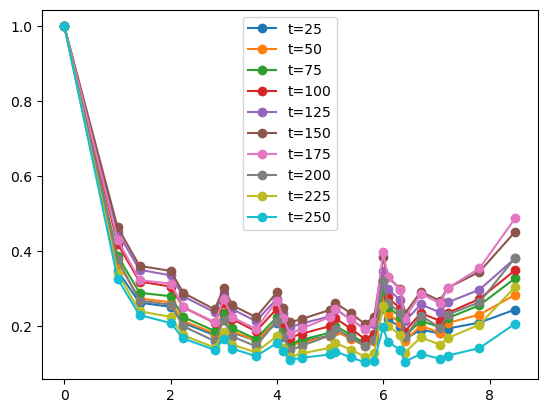

In [15]:
for key in corrfun_per_time.keys():
    plt.plot(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
plt.legend()

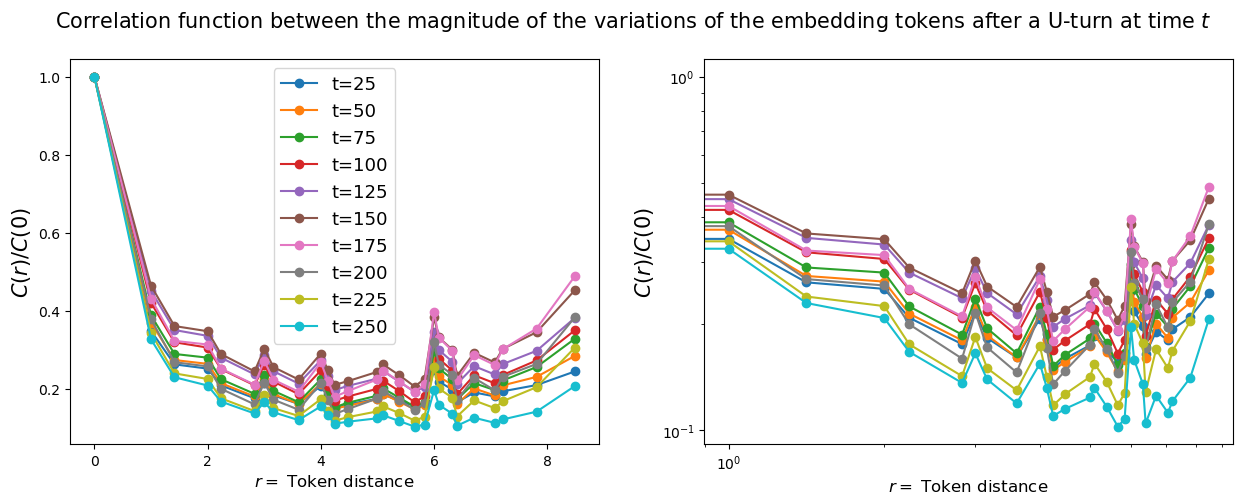

In [56]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

for key in corrfun_per_time.keys():
    axs[0].plot(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
    axs[1].loglog(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
axs[0].legend(prop={'size': 13})
axs[0].set_xlabel('$r=$ Token distance', fontsize=12)
axs[0].set_ylabel('$C(r)/C(0)$', fontsize=15)
axs[1].set_xlabel('$r=$ Token distance', fontsize=12)
axs[1].set_ylabel('$C(r)/C(0)$', fontsize=15)
#Title to the whole plot
fig.suptitle('Correlation function between the magnitude of the variations of the embedding tokens after a U-turn at time $t$', fontsize=15)
# fig.savefig(f'../../plots/clip-correlation_function.png', dpi = 300, bbox_inches='tight')
plt.show()


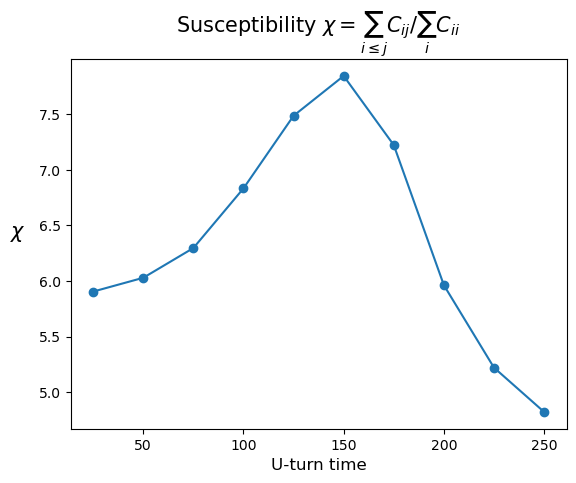

In [62]:
# chival = np.array([susceptibility_per_time[key] for key in susceptibility_per_time.keys()])
chival = np.array([susceptibility_per_time[key]/corrfun_per_time[key][0]/49 for key in susceptibility_per_time.keys()])
tvals = np.array([key for key in susceptibility_per_time.keys()])

fig, ax = plt.subplots()

ax.plot(tvals, chival, 'o-')
ax.set_xlabel('U-turn time', fontsize=12)
ax.set_ylabel('$\chi$', rotation=0, labelpad=15, fontsize=15)
ax.set_title('Susceptibility $\chi = \sum_{i\leq j}C_{ij}/\sum_{i}C_{ii}$', fontsize=15)

# chival = np.array([susceptibility_per_time[key]/49*100 for key in susceptibility_per_time.keys()])
# ax.plot(tvals, chival, 'o--')

# fig.savefig(f'../../plots/clip-susceptibility.png', dpi = 300, bbox_inches='tight')
plt.show()

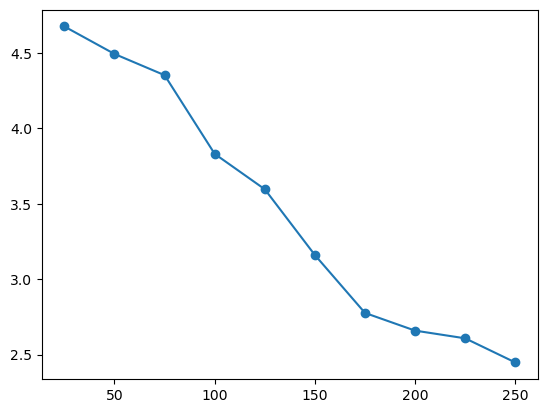

In [30]:
# chival = np.array([susceptibility_per_time[key] for key in susceptibility_per_time.keys()])
# chival = np.array([susceptibility_per_time[key]/corrfun_per_time[key][0] for key in susceptibility_per_time.keys()])
prod = [(feat_start[key] * feat_sample[key]).sum(axis=-1).mean()/512**0.5 for key in feat_start.keys()]
tvals = np.array([key for key in feat_start.keys()])

plt.plot(tvals, prod, 'o-')

In [29]:
(feat_start[key] * feat_sample[key]).sum(axis=-1).mean()/512**0.5

2.4472523755128166

# Clip - Trajectory avearges

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import time

from collections import defaultdict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Test

In [5]:
file = '/home/sclocchi/data/kuma_correlations/clip_correlation_seeds-t_25_250.pk'


with open(file, 'rb') as f:
    data = pickle.load(f)

data.keys()

dict_keys(['delta_dist', 'delta_Magn_dist', 'mean_delta_Cfun', 'mean_deltaMgn_Cfun', 'mean_delta_chi', 'mean_deltaMgn_chi', 'seed_correlations'])

In [4]:
data['seed_correlations']

{0: {'delta_Cfun': array([-0.27203542, -0.25979877, -0.24654442, -0.23685987, -0.23412113,
         -0.2285164 , -0.23380014, -0.23228668, -0.22404578, -0.23128574,
         -0.23069027, -0.21916187, -0.22174221, -0.22459495, -0.23493962,
         -0.22153942, -0.21476644, -0.21484153, -0.23799922, -0.22561145,
         -0.21253078, -0.21185534, -0.2104381 , -0.21249743, -0.20485133,
         -0.21534501, -0.23414479], dtype=float32),
  'delta_chi': array(-284.70868, dtype=float32),
  'deltaMgn_Cfun': array([0.00236063, 0.00028621, 0.00020379, 0.00019662, 0.00019791,
         0.00017021, 0.00018458, 0.0001754 , 0.0001183 , 0.00023281,
         0.00018085, 0.00014035, 0.00015737, 0.00018741, 0.00022849,
         0.00016958, 0.0001281 , 0.00023261, 0.00024511, 0.000301  ,
         0.00024747, 0.00027424, 0.00026295, 0.00028948, 0.00028484,
         0.0003043 , 0.00042298], dtype=float32),
  'deltaMgn_chi': array(0.35093236, dtype=float32),
  'sample_features': array([[ 0.7656 , -0.2585 ,

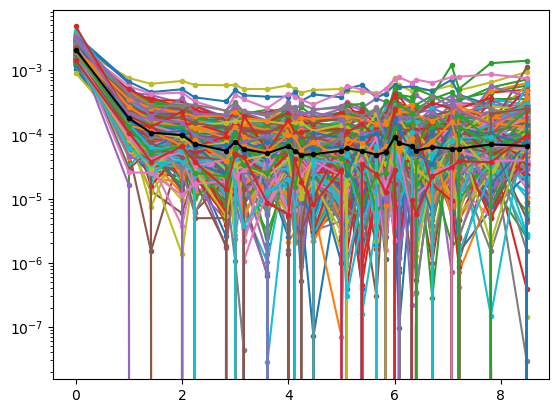

In [20]:
for seed in data['seed_correlations'].keys():
    seed_data = data['seed_correlations'][seed]
    plt.semilogy(data['delta_Magn_dist'], seed_data['deltaMgn_Cfun'], '.-')
    
plt.semilogy(data['delta_Magn_dist'], data['mean_deltaMgn_Cfun'], '.-', color='k')

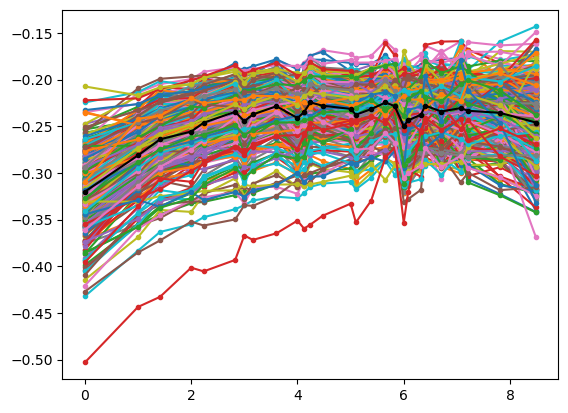

In [6]:
for seed in data['seed_correlations'].keys():
    seed_data = data['seed_correlations'][seed]
    plt.plot(data['delta_dist'], seed_data['delta_Cfun'], '.-')
    
plt.plot(data['delta_dist'], data['mean_delta_Cfun'], '.-', color='k')

In [8]:
3*364/60

18.2

### Analysis

In [3]:
keyfun = 'mean_deltaMgn_Cfun'
keydist = 'delta_Magn_dist'
keysus = 'mean_deltaMgn_chi'
corrfun_per_time = {}
dist_per_time = {}
susceptibility_per_time = {}
# feat_start = {}
# feat_sample = {}

for t in range(25, 275, 25):
    file = f'/home/sclocchi/data/kuma_correlations/diffused_ILSVRC2012_validation-seed_0/clip_correlation_seeds-t_{t}_250.pk'


    with open(file, 'rb') as f:
        data = pickle.load(f)

    # corr = data[key]

    # dist, Cfun, chi = compute_correlation_function(size=7, C=corr.reshape(49, 49))

    # corrfun_per_time[t] = Cfun
    # dist_per_time[t] = dist
    # susceptibility_per_time[t] = chi
    corrfun_per_time[t] = data[keyfun]
    dist_per_time[t] = data[keydist]
    susceptibility_per_time[t] = data[keysus]
    # feat_start[t] = data['start_feat']
    # feat_sample[t] = data['sample_feat']

    print(f'Computed correlation function at time {t}.')

print(data.keys())

Computed correlation function at time 25.
Computed correlation function at time 50.
Computed correlation function at time 75.
Computed correlation function at time 100.
Computed correlation function at time 125.
Computed correlation function at time 150.
Computed correlation function at time 175.
Computed correlation function at time 200.
Computed correlation function at time 225.
Computed correlation function at time 250.
dict_keys(['delta_dist', 'delta_Magn_dist', 'mean_delta_Cfun', 'mean_deltaMgn_Cfun', 'mean_delta_chi', 'mean_deltaMgn_chi', 'seed_correlations'])


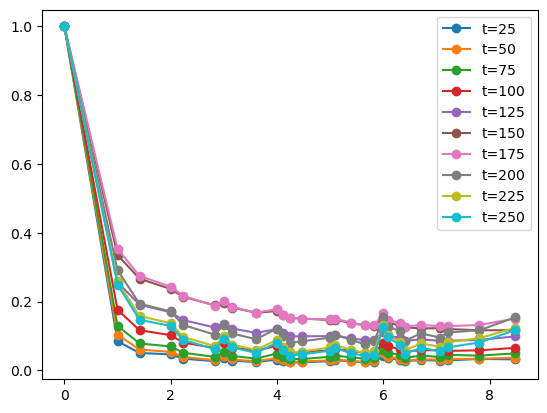

In [4]:
for key in corrfun_per_time.keys():
    plt.plot(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
plt.legend()

/tmp/ipykernel_21972/2956728352.py:6: RuntimeWarning: divide by zero encountered in power
  axs[0].plot(dist_per_time[key], .4*(dist_per_time[key] / dist_per_time[key][1])**(-.5), 'k--', label=f'r^{-.5}')
/tmp/ipykernel_21972/2956728352.py:7: RuntimeWarning: divide by zero encountered in power
  axs[1].loglog(dist_per_time[key], .4*(dist_per_time[key] / dist_per_time[key][1])**(-.5), 'k--', label=f'r^{-.5}')


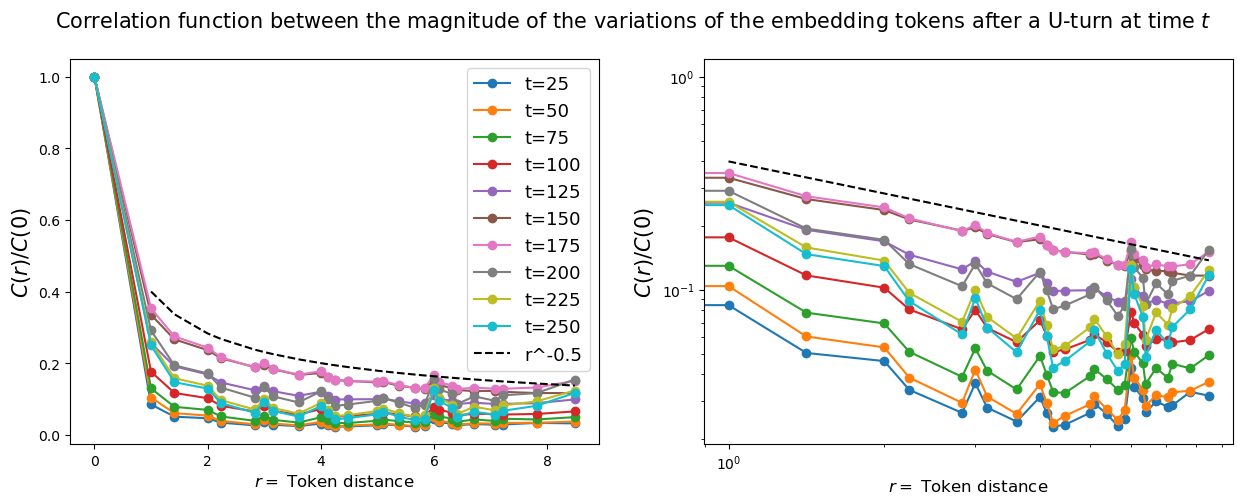

In [71]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

for key in corrfun_per_time.keys():
    axs[0].plot(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
    axs[1].loglog(dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', label=f't={key}')
axs[0].plot(dist_per_time[key], .4*(dist_per_time[key] / dist_per_time[key][1])**(-.5), 'k--', label=f'r^{-.5}')
axs[1].loglog(dist_per_time[key], .4*(dist_per_time[key] / dist_per_time[key][1])**(-.5), 'k--', label=f'r^{-.5}')
axs[0].legend(prop={'size': 13})
axs[0].set_xlabel('$r=$ Token distance', fontsize=12)
axs[0].set_ylabel('$C(r)/C(0)$', fontsize=15)
axs[1].set_xlabel('$r=$ Token distance', fontsize=12)
axs[1].set_ylabel('$C(r)/C(0)$', fontsize=15)
#Title to the whole plot
fig.suptitle('Correlation function between the magnitude of the variations of the embedding tokens after a U-turn at time $t$', fontsize=15)
# fig.savefig(f'../../plots/clip-correlation_function.png', dpi = 300, bbox_inches='tight')
plt.show()


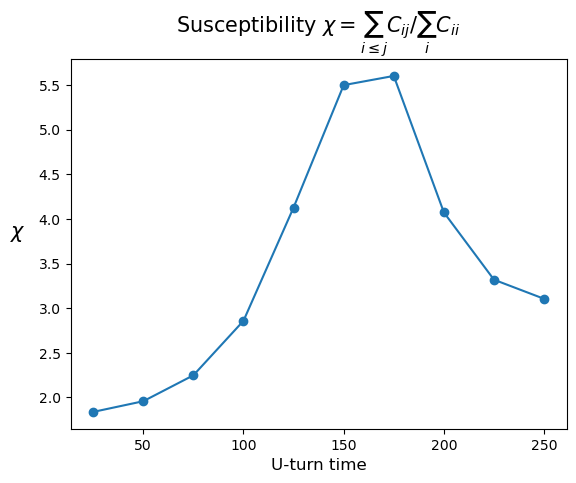

In [72]:
# chival = np.array([susceptibility_per_time[key] for key in susceptibility_per_time.keys()])
chival = np.array([susceptibility_per_time[key]/corrfun_per_time[key][0]/49 for key in susceptibility_per_time.keys()])
tvals = np.array([key for key in susceptibility_per_time.keys()])

fig, ax = plt.subplots()

ax.plot(tvals, chival, 'o-')
ax.set_xlabel('U-turn time', fontsize=12)
ax.set_ylabel('$\chi$', rotation=0, labelpad=15, fontsize=15)
ax.set_title('Susceptibility $\chi = \sum_{i\leq j}C_{ij}/\sum_{i}C_{ii}$', fontsize=15)

# chival = np.array([susceptibility_per_time[key]/49*100 for key in susceptibility_per_time.keys()])
# ax.plot(tvals, chival, 'o--')

# fig.savefig(f'../../plots/clip-susceptibility.png', dpi = 300, bbox_inches='tight')
plt.show()

### Paper plots

In [24]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

## LateX rendering
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 16,
    'lines.markersize':6,
#     "font.weight" : "bold",
#     "axes.labelweight" : "bold",
})

# # ## Normal rendering
# plt.rcParams.update(plt.rcParamsDefault)
# matplotlib.rcParams.update({
#     # "text.usetex": True,
#     "font.family": "DejaVu Serif",
#     "font.serif": ["Times New Roman"],
#     # 'pgf.rcfonts': False,
#     'font.size': 16,
#     # 'mathtext.fontset': 'cm'
# })

color_points = ['indigo', 'C4', 'C0', 'C2', 'C1', 'C3']
cmap = LinearSegmentedColormap.from_list('perceptual_noise', color_points)

In [25]:
colors = cmap(np.linspace(0,1, len(corrfun_per_time.keys())))

fig, ax = plt.subplots()

for key, col in zip(corrfun_per_time.keys(), colors):
    ax.loglog(1+dist_per_time[key], corrfun_per_time[key] / corrfun_per_time[key][0], 'o-', lw=2, label=f't={key/250:.1f} T', color = col)

# ax.plot(dist_per_time[key], .4*(dist_per_time[key] / dist_per_time[key][1])**(-.5), 'k--', label=f'r^{-.5}')
ax.legend(ncol=2, prop={'size': 12})
ax.set_xlabel('$1+r$', fontsize=20)
ax.set_ylabel('$C(r, t)\ /\ C(0, t)$', fontsize=20)

# Set x ticks from 1 to 8
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
# Set x tick labels to be the square root of the distance
ax.set_xticklabels([f'{i}' for i in range(1, 9)])

# fig.savefig(f'../../plots/clip-average_correlation_function.pdf', dpi = 300, bbox_inches='tight')
# fig.savefig(f'../../plots/clip-average_correlation_function-r_plus_1.pdf', dpi = 300, bbox_inches='tight')

fig.savefig(f'../../plots/clip-average_correlation_function-r_plus_1-styled.pdf', dpi = 300, bbox_inches='tight')
plt.show()


In [27]:
chival = np.array([susceptibility_per_time[key]/corrfun_per_time[key][0]/49 for key in susceptibility_per_time.keys()])
tvals = np.array([key for key in susceptibility_per_time.keys()])

fig, ax = plt.subplots()

ax.plot(tvals/250, chival, 'o-', lw=2)
ax.set_xlabel('t / T', fontsize=20)
ax.set_ylabel('$\chi(t)$', rotation=0, labelpad=20, fontsize=20)

# add minorticks on the y and x axis
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

# fig.savefig(f'../../plots/clip-average_susceptibility.pdf', dpi = 300, bbox_inches='tight')

fig.savefig(f'../../plots/clip-average_susceptibility-styled.pdf', dpi = 300, bbox_inches='tight')

plt.show()

### Trajectories analysis

In [ ]:
for seed in data['seed_correlations'].keys():
    seed_data = data['seed_correlations'][seed]
    plt.semilogy(data['delta_Magn_dist'], seed_data['deltaMgn_Cfun'], '.-')
    
plt.semilogy(data['delta_Magn_dist'], data['mean_deltaMgn_Cfun'], '.-', color='k')

In [73]:
chi_seeds = {}
for seed in range(0,len(data['seed_correlations'].keys())):
    chi_seeds[seed] = []


for t in range(25, 275, 25):
    file = f'/home/sclocchi/data/kuma_correlations/diffused_ILSVRC2012_validation-seed_0/clip_correlation_seeds-t_{t}_250.pk'

    with open(file, 'rb') as f:
        data = pickle.load(f)

    seed_data = data['seed_correlations']
    for seed in seed_data.keys():
        chi_seeds[seed].append(seed_data[seed]['deltaMgn_chi'])
        
    # corr = data[key]

    # dist, Cfun, chi = compute_correlation_function(size=7, C=corr.reshape(49, 49))

    # corrfun_per_time[t] = Cfun
    # dist_per_time[t] = dist
    # susceptibility_per_time[t] = chi
    # corrfun_per_time[t] = data[keyfun]
    # dist_per_time[t] = data[keydist]
    # susceptibility_per_time[t] = data[keysus]
    # feat_start[t] = data['start_feat']
    # feat_sample[t] = data['sample_feat']

    print(f'Computed correlation function at time {t}.')

print(data.keys())

Computed correlation function at time 25.
Computed correlation function at time 50.
Computed correlation function at time 75.
Computed correlation function at time 100.
Computed correlation function at time 125.
Computed correlation function at time 150.
Computed correlation function at time 175.
Computed correlation function at time 200.
Computed correlation function at time 225.
Computed correlation function at time 250.
dict_keys(['delta_dist', 'delta_Magn_dist', 'mean_delta_Cfun', 'mean_deltaMgn_Cfun', 'mean_delta_chi', 'mean_deltaMgn_chi', 'seed_correlations'])


In [31]:
seed_data['deltaMgn_chi']

array(0.3818546, dtype=float32)

Text(0, 0.5, '$\\chi$')

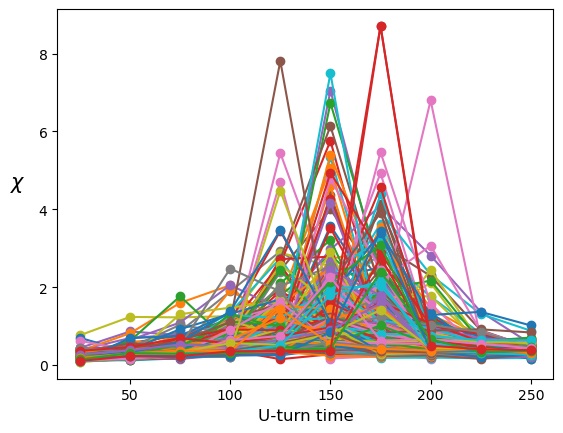

In [76]:
for seed in chi_seeds.keys():
    plt.plot(tvals, chi_seeds[seed], 'o-')
plt.xlabel('U-turn time', fontsize=12)
plt.ylabel('$\chi$', rotation=0, labelpad=15, fontsize=15)

(array([74., 86., 66., 46., 26., 18.,  8.,  9.,  6.,  5.,  6.,  2.,  4.,
         1.,  0.,  3.,  0.,  2.,  0.,  2.]),
 array([0.42334825, 0.8377099 , 1.25207162, 1.66643333, 2.08079505,
        2.49515653, 2.90951824, 3.32387996, 3.73824167, 4.15260315,
        4.5669651 , 4.98132658, 5.39568853, 5.81005001, 6.22441149,
        6.63877344, 7.05313492, 7.46749687, 7.88185835, 8.29621983,
        8.71058178]),
 <BarContainer object of 20 artists>)

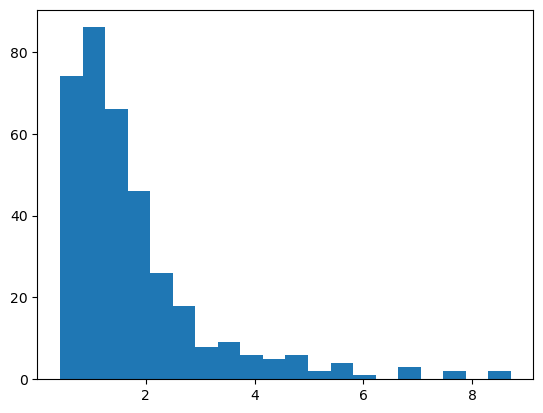

In [79]:
max_chi = []
for seed in chi_seeds.keys():
    max_chi.append(max(chi_seeds[seed]))

plt.hist(max_chi, bins=20)

In [77]:
median_chi = []
mean_chi = []
for it,t in enumerate(range(25, 275, 25)):
    median_chi.append(np.median([chi_seeds[seed][it] for seed in chi_seeds.keys()]))
    mean_chi.append(np.mean([chi_seeds[seed][it] for seed in chi_seeds.keys()]))

median_chi = [median_chi[it]/corrfun_per_time[key][0]/49 for it,key in enumerate(susceptibility_per_time.keys())]
mean_chi = [mean_chi[it]/corrfun_per_time[key][0]/49 for it,key in enumerate(susceptibility_per_time.keys())]

Text(0.5, 1.0, 'Susceptibility $\\chi$: mean vs median over starting images')

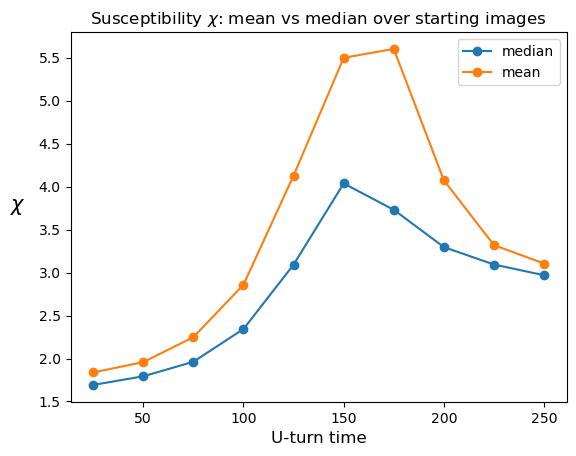

In [78]:
plt.plot(tvals, median_chi, 'o-', label='median')
plt.plot(tvals, mean_chi, 'o-', label='mean')
plt.legend()
plt.xlabel('U-turn time', fontsize=12)
plt.ylabel('$\chi$', rotation=0, labelpad=15, fontsize=15)
plt.title('Susceptibility $\chi$: mean vs median over starting images', fontsize=12)
